In [1]:
%run "dev.ipynb"


In [2]:
gro = "../binding_spots_project/gpcr_sampling/b2ar-fst/chol-sdpc/a100/epoch01/rep01/solu_memb.gro"
trajs = glob.glob("../binding_spots_project/gpcr_sampling/b2ar-fst/chol-sdpc/a100/epoch*/rep*/solu_memb_centered.xtc")
cosmos = mda.Universe(gro, trajs, reload_offsets=True)
print(cosmos.trajectory.n_frames)

64128


In [3]:
sdpc_cc = load_dataset(filename="./data/sdpc-protein-cross-contact-chol-sdpc-a100.npy", skip=10)
chol_cc = load_dataset(filename="./data/o3-protein-cross-contact-chol-sdpc-a100.npy", skip=10)
fvals = load_dataset(filename="./data/chol-sdpc-a100-values.npy", skip=10)

In [4]:
print(chol_cc.shape, fvals.shape)

(6413, 23325) (6413, 1)


In [5]:
pls_chol = OPLS_PLS(pls_components=2, n_components=2).fit(chol_cc, fvals)

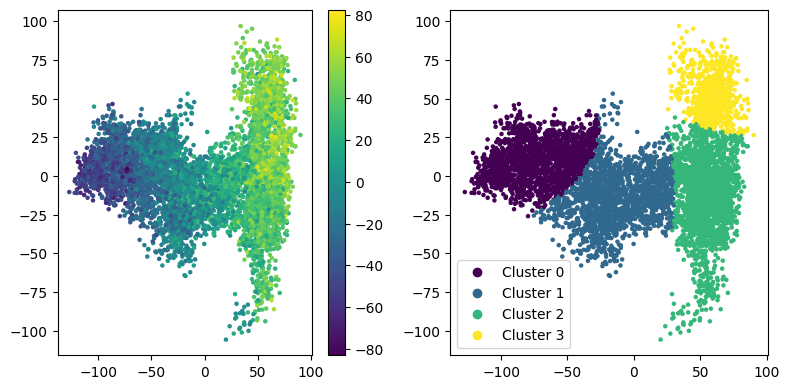

In [6]:
T = pls_chol.transform(chol_cc)
gmm = GaussianMixture(n_components=4, covariance_type="diag")
preds = gmm.fit(T).predict(T)
reordered_preds, D = reorder_clusters(T, fvals, preds)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax0 = ax[0].scatter(T[:,0], T[:,1], s=5, c=fvals)
plt.colorbar(ax0,ax=ax[0])

scatter = ax[1].scatter(T[:,0], T[:,1], s=5, c=reordered_preds)
plt.legend(handles=scatter.legend_elements()[0], labels=[f"Cluster {i}" for i in range(len(set(reordered_preds)))])
plt.tight_layout()

In [7]:
check_robustness(20, .25, T, fvals, 4, covariance_type="diag")

Mean fraction: 0.9585451426789333, fraction STD 0.09857611425257867 worst fraction: 0.5


In [ ]:
T = pls_chol.transform(chol_cc)
gmm = GaussianMixture(n_components=4, covariance_type="diag")
preds = gmm.fit(T).predict(T)
reordered_preds, D = reorder_clusters(T, fvals, preds)

-31.256630287738908
-34.50172519683838
--------
0.4008165727712767
-3.825992689132704
--------
37.501963005498965
36.35364603996274
--------
45.52362914806155
49.35501611709594
--------


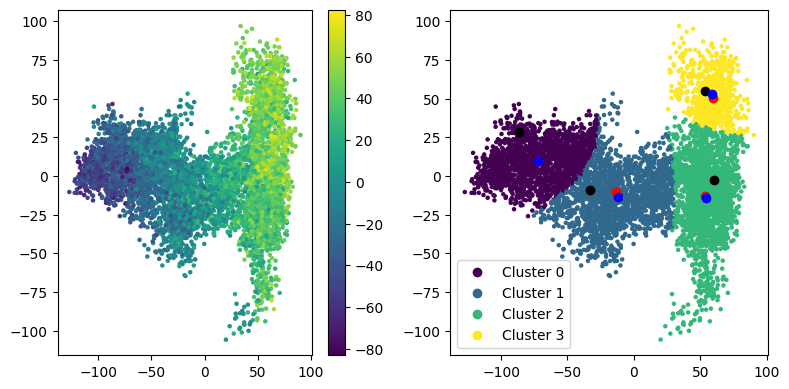

In [14]:

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax0 = ax[0].scatter(T[:,0], T[:,1], s=5, c=fvals)
plt.colorbar(ax0,ax=ax[0])

scatter = ax[1].scatter(T[:,0], T[:,1], s=5, c=reordered_preds)
plt.legend(handles=scatter.legend_elements()[0], labels=[f"Cluster {i}" for i in range(len(set(reordered_preds)))])
plt.tight_layout()

for p in set(reordered_preds):
    
    mask = (reordered_preds == p)
    cluster_fvals = fvals[mask]
    cluster_T = T[mask,:]
    original_cluster = [k for k, v in D.items() if v == p][0]
    cluster_probs = gmm.predict_proba(cluster_T)[:,original_cluster]
    most_prob = cluster_probs.argmax(axis=0)
    
    cluster_center = gmm.means_[original_cluster].reshape(1, -1) # position of mean of cluster
    distances = scipy.spatial.distance.cdist(cluster_T, cluster_center, 'euclidean') # data point distances to mean
    
    closest_index = np.argmin(distances) 
    closest_point = cluster_T[closest_index,:]
    closest = np.where(np.all(T == closest_point, axis=1))[0][0]  # Closest point in DR representation
    
    ax[1].scatter([closest_point[0]], [closest_point[1]], c="r")
    ax[1].scatter([T[most_prob,0]], [T[most_prob, 1]], c="k")
    ax[1].scatter([cluster_T[:,0].mean()], [cluster_T[:,1].mean()], c="b")
    
    


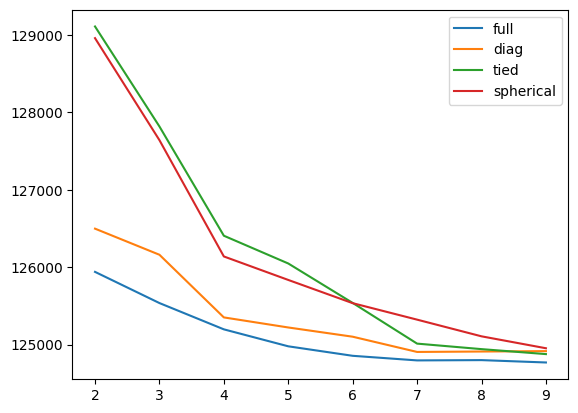

In [7]:
plot_bics(T, 10)

In [8]:
check_robustness(20, .25, T, fvals, 4, covariance_type="diag")

Mean fraction: 0.961733977857477, fraction STD 0.0941361358032488 worst fraction: 0.5
